[DIY Covid-19 Dashboard Kit](https://github.com/fsmeraldi/diy-covid19dash) (C) Oliver Kensington, 2020 All rights reserved.

In [1]:
import ipywidgets as wdg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from uk_covid19 import Cov19API

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

## United Kingdom Covid-19 Dashboard 

Please refer to the graph below for an overview of the overall confirmed cases of COVID-19 in the United Kingdom. This graph is refreshed everytime the page is loaded, so it is always displaying the latest data. 

Text(0, 0.5, 'cases')

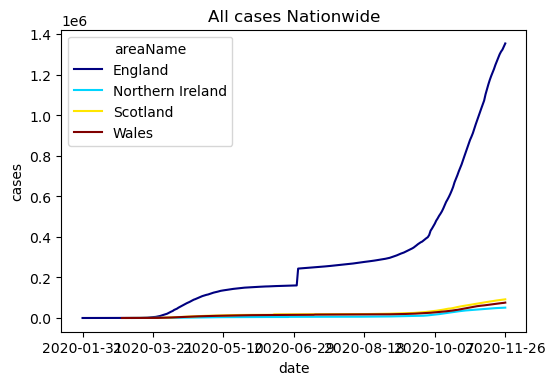

In [2]:
all_nations = [
    "areaType=nation"
]

cases_and_deaths = {
    "date": "date",
    "areaName": "areaName",
    "cumCasesByPublishDate": "cumCasesByPublishDate",
}

allapi = Cov19API(
    filters=all_nations,
    structure=cases_and_deaths
)

alldf = allapi.get_dataframe()

alldf=alldf.pivot(index="date", columns= "areaName" , values= "cumCasesByPublishDate")

ax = alldf.plot(colormap='jet', markersize=10, title='All cases Nationwide')
ax.set_ylabel("cases")

In [3]:
## This graph was working brilliantly with the data from a week ago but suddenly all the data is coming up as zero ##
## Leaving this here as I like using the area graph to display planned capacity over cases - will come back to it ##

#with open("ocvscap.json", "rt") as INFILE:
   # data=json.load(INFILE)
    

In [4]:
## datalist=data['data']
## dates=[dictionary['date'] for dictionary in datalist ]
## dates.sort()
## def parse_date(datestring):
##     return pd.to_datetime(datestring, format="%Y-%m-%d")
## startdate=parse_date(dates[0])
## enddate=parse_date(dates[-1])
## index=pd.date_range(startdate, enddate, freq='D')
## plancapdf=pd.DataFrame(index=index, columns=['newadmissions', 'hospitalcases', 'plannedcapacity'])


## for entry in datalist: 
##     date=parse_date(entry['date'])
## for column in ['newadmissions', 'hospitalcases', 'plannedcapacity']:

##     if pd.isna(plancapdf.loc[date, column]):  
##         value= float(entry[column]) if entry[column]!=None else 0.0 
##         plancapdf.loc[date, column]=value 
## plancapdf.fillna(0.0, inplace=True)


## plancapdf=wrangle_data(data) 
## plancapdf

The graph below compares the new tests and new cases of COVID-19 across the United Kingdom, you can use the update button below to refresh the data to the latest available from the UK GOV website. 

You can also use the controls to for alternate displays. 

In [5]:
with open ("testcase.json", "rt") as INFILE:
    data = json.load(INFILE)

In [6]:
def wrangle_data(rawdata):

    datalist=data['data']
    dates=[dictionary['date'] for dictionary in datalist ]
    dates.sort()
    def parse_date(datestring):
        """ Convert a date string into a pandas datetime object """
        return pd.to_datetime(datestring, format="%Y-%m-%d")
    startdate=parse_date(dates[0])
    enddate=parse_date(dates[-1])
    index=pd.date_range(startdate, enddate, freq='D')
    timeseriesdf=pd.DataFrame(index=index, columns=['newcases', 'newtests'])

    for entry in datalist: 
        date=parse_date(entry['date'])
        for column in ['newcases', 'newtests']:
            
            if pd.isna(timeseriesdf.loc[date, column]):  
                value= float(entry[column]) if entry[column]!=None else 0.0
                timeseriesdf.loc[date, column]=value
            
    timeseriesdf.fillna(0.0, inplace=True)
    return timeseriesdf


df=wrangle_data(data) 

In [7]:
def access_api():
    """ Accesses the PHE API. Returns raw data in the same format as data loaded from the "canned" JSON file. """

    filters = [
    "areaType=nation",
    "areaName=England",
    ]

    structure = {
    "date": "date",
    "newcases": "newCasesByPublishDate",
    "newtests": "newTestsByPublishDate",
    }

    api = Cov19API(filters=filters, structure=structure)

    return {api}

In [8]:
def api_button_callback(button):
    """ Button callback - it must take the button as its parameter (unused in this case).
    Accesses API, wrangles data, updates global variable df used for plotting. """
    apidata=access_api()
    global df
    df=wrangle_data(apidata)
    
    apibutton.icon="check"
    
apibutton=wdg.Button(
    description='Update', 
    disabled=False,
    button_style='info', 
    tooltip="Refresh Data",
    icon='angle-double-down'
)


apibutton.on_click(api_button_callback) 

display(apibutton)

Button(button_style='info', description='Update', icon='angle-double-down', style=ButtonStyle(), tooltip='Refr…

In [9]:
series=wdg.SelectMultiple(
    options=['newcases', 'newtests'],
    value=['newcases', 'newtests'],
    rows=2,
    description='Stats:',
    disabled=False
)

scale=wdg.RadioButtons(
    options=['linear', 'log'],
    description='Scale:',
    disabled=False
)

controls=wdg.VBox([series, scale])

def testcase_graph(gcols, gscale):
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        df[list(gcols)].plot(logy=logscale)
    else:
        print("Choose data for graph")
        print("Use the command button to select both values")

   
TestCasegraph=wdg.interactive_output(testcase_graph, {'gcols': series, 'gscale': scale})


display(controls, TestCasegraph)


Output()

Our final graph compares the positive case distribution among males and females, you can select both using the command button for a total view. 


The data for this graph will be updates periodically.

In [10]:
with open ("agedistribution.json", "rt") as INFILE:
    data=json.load(INFILE)

In [11]:
#def munge_data(grossdata): ## not sure why this is not working now, resorted to using JSON Data ##

datadic=data['data'][0] 
datadic
males=datadic['males']
females=datadic['females']
agerange=[x['age'] for x in males]
def min_age(agerange):
    agerange=agerange.replace('+','') 
    start=agerange.split('_')[0]
    return int(start)
agerange.sort(key=min_age)
age_df=pd.DataFrame(index=agerange, columns=['males','females', 'total'])

for entry in males: 
    ageband=entry['age'] 
    age_df.loc[ageband, 'males']=entry['value']

for entry in females:
    ageband=entry['age']
    age_df.loc[ageband, 'females']=entry['value']


#age_df['total']=age_df['males']+age_df['females']


In [12]:
agecols=wdg.SelectMultiple(
    options=['males', 'females'],
    value=['males', 'females'],
    rows=2,
    description='Sex',
    disabled=False
)

def age_graph(graphcolumns):
    ncols=len(graphcolumns)
    if ncols>0:
        age_df.plot(kind='bar', y=list(graphcolumns), stacked=True) 
    else:
        print("Choose data for graph")
        print("Use the command button to select both values for a total")
        
output=wdg.interactive_output(age_graph, {'graphcolumns': agecols})

display(agecols, output)

SelectMultiple(description='Sex', index=(0, 1), options=('males', 'females'), rows=2, value=('males', 'females…

Output()

*Based on UK Government [data](https://coronavirus.data.gov.uk/) published by [Public Health England](https://www.gov.uk/government/organisations/public-health-england).*